# Supervised Machine Learning - Linear Regression

After the the creation of the database, we connect to the database and perform the following:
- Determine number of rows with blank cells. Because there were only five, we dropped those cells
- We dropped the happinessrank, lat, and lng columns because they were unnecessary 
- We created a seprate dataframe and dropped the index, then exported for use in R Studio (both simple linear calculations and a multiple linear regression were perfored in R Studio -- see images for results). Addionally, in R Studio the data was split into training and testing sets by creating two random sets (P1 - training,  and P2 - testing). P1 contains the first 50 rows of random data, P2 contains the rest.
- Finally, we dropped the country column because it was no longer necessary and changed the data type from object to float.

This model was chosen because we are able to measure each (and several in the case of multiple linear regression), features against "happinessscore" to see how/whether they are related.

## Connect to Database

In [1]:
# Import Dependencies
import psycopg2
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Connection parameters
from config import username
from config import password
param_dic = {
    "host"      : "whr.csnc4l4qvlqd.us-east-2.rds.amazonaws.com",
    "database"  : "postgres",
    "user"      : "username",
    "password"  : "password"
}

# Create connect function to connect to PostgresSQL server
def connect(param_dic):
    conn = None
    try:
        print("Connecting to the PostgreSQL database...")
        conn = psycopg2.connect(**param_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    print ("Connection successful.")
    return conn
    

In [3]:
# Function to get the dataframe
def postgresql_to_dataframe(conn, select_query, column_names):
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
            print("Error: %s" % error)
            cursor.close()
    
    # Get list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    
    # Create pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

In [4]:
# Connect to the database
conn = connect(param_dic)

column_names = ["country", "happinessrank", "happinessscore", "gdp", "family", "lifeexpectancy", "freedom", "generosity", "trust", "lat", "lng", "alcohol_liperyear"]
df = postgresql_to_dataframe(conn, "select * from whr_2019", column_names)
df.head()

Connecting to the PostgreSQL database...
Connection successful.


,country,happinessrank,happinessscore,gdp,family,lifeexpectancy,freedom,generosity,trust,lat,lng,alcohol_liperyear
0,Brazil,32,6.300,1.00400,1.43900,0.80200,0.39000,0.09900,0.08600,-14.235004,-51.925280,19.3
1,Uruguay,33,6.293,1.12400,1.46500,0.89100,0.52300,0.12700,0.15000,-32.522779,-55.765835,15.7
2,Singapore,34,6.262,1.57200,1.46300,1.14100,0.55600,0.27100,0.45300,1.352083,103.819836,2.9
3,El Salvador,35,6.253,0.79400,1.24200,0.78900,0.43000,0.09300,0.07400,13.794185,-88.896530,12.8
4,Italy,36,6.223,1.29400,1.48800,1.03900,0.23100,0.15800,0.03000,41.871940,12.567380,12.0


In [5]:
# Display countries with null values
df1 = df[df.isna().any(axis=1)]
df1

,country,happinessrank,happinessscore,gdp,family,lifeexpectancy,freedom,generosity,trust,lat,lng,alcohol_liperyear
13,Kosovo,46,6.100,0.88200,1.23200,0.75800,0.48900,0.26200,0.00600,42.602636,20.902977,None
42,Hong Kong,76,5.430,1.43800,1.27700,1.12200,0.44000,0.25800,0.28700,22.396428,114.109497,None
69,Palestinian Territories,110,4.696,0.65700,1.24700,0.67200,0.22500,0.10300,0.06600,31.952162,35.233154,None
111,Taiwan,25,6.446,1.36800,1.43000,0.91400,0.35100,0.24200,0.09700,23.697810,120.960515,None
152,Macedonia [FYROM],84,5.274,0.98300,1.29400,0.83800,0.34500,0.18500,0.03400,41.608635,21.745275,None


In [6]:
# Since there are only 5 countries, drop countries with null values
df = df.dropna()
df2 = df[df.isna().any(axis=1)]
df2

,country,happinessrank,happinessscore,gdp,family,lifeexpectancy,freedom,generosity,trust,lat,lng,alcohol_liperyear


In [7]:
# Drop unnecessariy columns
df = df.drop(columns=["happinessrank", "lat", "lng"], axis=1)
df = df.fillna(value=np.nan)
df.dtypes

country              object
happinessscore       object
gdp                  object
family               object
lifeexpectancy       object
freedom              object
generosity           object
trust                object
alcohol_liperyear    object
dtype: object

In [8]:
# Write df to csv file for R Studio 
df.reset_index(drop=True, inplace=True)
df.to_csv("sml_linreg.csv", index=False)

In [9]:
# Drop "country" column and make type float
df = df.drop(columns=["country"])
df = df[0:153].astype(float, errors = 'raise')
df.tail()

,happinessscore,gdp,family,lifeexpectancy,freedom,generosity,trust,alcohol_liperyear
144,4.812,0.673,0.799,0.508,0.372,0.105,0.093,15.1
145,4.418,0.094,1.125,0.357,0.269,0.212,0.053,7.1
146,4.944,0.569,0.808,0.232,0.352,0.154,0.090,21.7
147,4.360,0.710,1.181,0.555,0.525,0.566,0.172,17.6
148,6.192,1.231,1.477,0.713,0.489,0.185,0.016,14.2


In [10]:
df.dtypes

happinessscore       float64
gdp                  float64
family               float64
lifeexpectancy       float64
freedom              float64
generosity           float64
trust                float64
alcohol_liperyear    float64
dtype: object

## Predicting GDP - Happiness

In [11]:
# GDP
X = df.gdp
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [12]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

0.2285034323602151

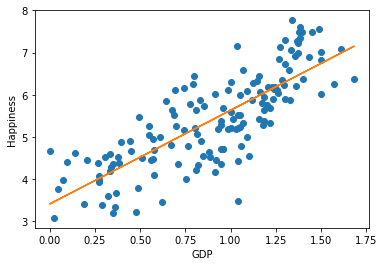

In [13]:
# Plot
x = np.array(df.gdp)
y = np.array(df.happinessscore)
plt.xlabel("GDP")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)



## Predicting Family - Happiness

In [14]:
# Family
X = df.family
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [15]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

0.5552254934887999

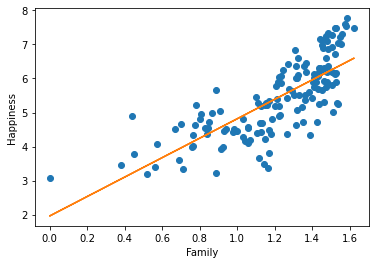

In [16]:
# Plot
x = np.array(df.family)
y = np.array(df.happinessscore)
plt.xlabel("Family")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

## Predicting Life Expectancy - Happiness

In [17]:
# Life Expectancy
X = df.lifeexpectancy
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [18]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

0.38209836416136744

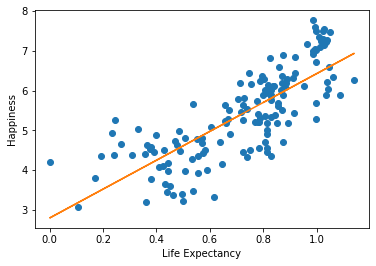

In [19]:
# Plot
x = np.array(df.lifeexpectancy)
y = np.array(df.happinessscore)
plt.xlabel("Life Expectancy")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

## Predicting Freedom - Happiness

In [20]:
# Freedom
X = df.freedom
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [21]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

-0.2384602521047232

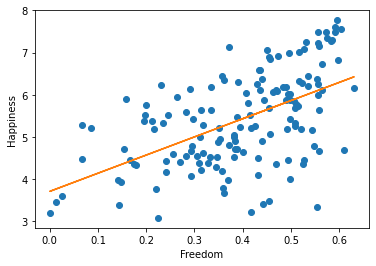

In [22]:
# Plot
x = np.array(df.freedom)
y = np.array(df.happinessscore)
plt.xlabel("Freedom")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

## Predicting Trust - Happiness

In [23]:
# Trust
X = df.trust
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [24]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

-0.6650130057967689

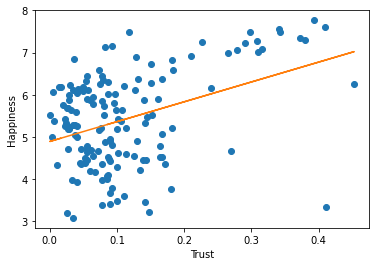

In [25]:
# Plot
x = np.array(df.trust)
y = np.array(df.happinessscore)
plt.xlabel("Trust")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

## Predicting Generosity - Happiness

In [26]:
# Generosity
X = df.generosity
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [27]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

-0.13283466962746182

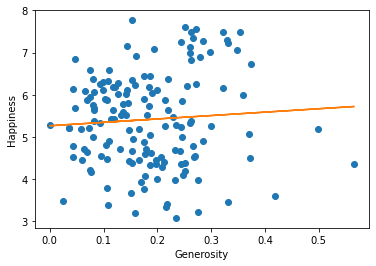

In [28]:
# Plot
x = np.array(df.generosity)
y = np.array(df.happinessscore)
plt.xlabel("Generosity")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

## Predicting Alcohol Consumption - Happiness

In [29]:
# Alcohol Consumption
X = df.alcohol_liperyear
y = df.happinessscore
X_b = np.c_[np.ones((149, 1)), X]  # Adding the bias term which is equal to 1

# Dividing the data into train and test sets    
X_train, X_test, y_train, y_test = train_test_split(X_b, y, test_size=0.2, random_state=42)

theta_optimize = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [30]:
# Predicting new data with the obtained feature weights
y_pred = X_test.dot(theta_optimize)
r2_score(y_test, y_pred)

-0.10324748201100009

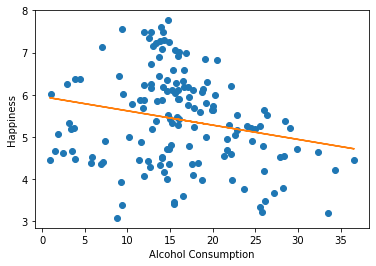

In [31]:
# Plot
x = np.array(df.alcohol_liperyear)
y = np.array(df.happinessscore)
plt.xlabel("Alcohol Consumption")
plt.ylabel("Happiness")
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

In [32]:
# Close the connection
conn.close()